In [39]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

def create_geometry(x1,x2,y1,y2):
    elements = []
    element = {}
    for i in range(len(x1)):
        element["x1"] = x1[i]
        element["y1"] = y1[i]
        element["x2"] = x2[i]
        element["y2"] = y2[i]
        elements.append(element.copy())
    elements = bemcs.standardize_elements(elements)
    return elements

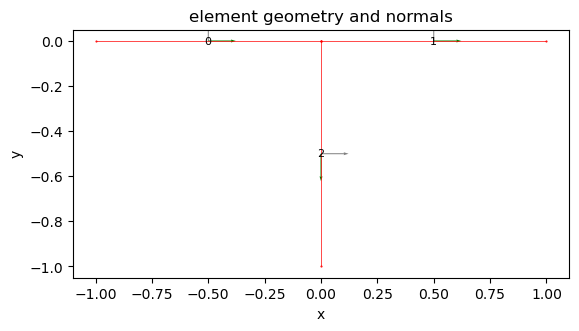

In [40]:
# Elastic parameters
mu = 1
nu = 0.25

x1 = np.array((-1.,0,0))
x2 = np.array((0.,1.,0.))
y1 = np.array((0.,0.,0.))
y2 = np.array((0.,0.,-1.))

elements = create_geometry(x1,x2,y1,y2)
n_elements = len(elements)

# slip vector
slip_vector_x = np.array((1.,1.0,0.))
slip_vector_y = np.array((0.,0.,1.0))

plt.figure()
bemcs.plot_element_geometry(elements)
plt.show()

In [41]:
# observation point
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# convert to traction kernels [Nobs x Ncoefficients]
# tx = Kxx*nx + Kxy*ny
# ty = Kxy*nx + Kyy*ny
# tractionkernels_s = kernels.compute_tractionkernels(elements,kernels_s)
# tractionkernels_n = kernels.compute_tractionkernels(elements,kernels_n)

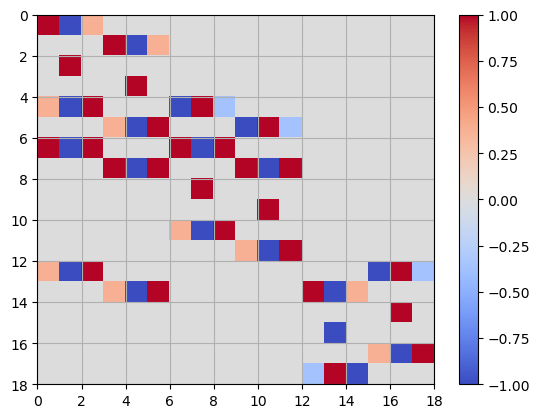

In [42]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")

Nequations = len(elements)*6
Nunknowns = len(elements)*6

# normally this matrix is square but for a 3 fault segment it may not be - need to investigate
matrix_system = np.zeros((Nequations,Nunknowns))

BCvector = np.zeros((Nequations,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
# BCvector[0:2] = 0.
# BCvector[-2:] = 0.
# slip boundary condition for element centers
BCvector[2::6] = slip_vector_x.reshape((-1,1))
BCvector[3::6] = slip_vector_y.reshape((-1,1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slip[0:2:] # first element open node
matrix_system[10:12,:] = matrix_slip[10:12:] # second element open node
matrix_system[16:18,:] = matrix_slip[16:18,:] # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6,:] = matrix_slip[2::6,:] # x component
matrix_system[3::6,:] = matrix_slip[3::6,:] # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
# elements 1 and 2
matrix_system[4,:] = matrix_slip[4,:] - matrix_slip[6,:]# x component
matrix_system[5,:] = matrix_slip[5,:] - matrix_slip[7,:]# y component
# elements 1 and 3
matrix_system[12,:] = matrix_slip[4,:] - matrix_slip[12,:]# x component
matrix_system[13,:] = matrix_slip[5,:] - matrix_slip[13,:]# y component

# smoothness
# elements 1 and 2
matrix_system[6,:] = matrix_slipgradient[4,:] - matrix_slipgradient[6,:]# x component
matrix_system[7,:] = matrix_slipgradient[5,:] - matrix_slipgradient[7,:]# y component 
# elements 1 and 3
if Nequations>Nunknowns:
    matrix_system[18,:] = matrix_slipgradient[4,:] - matrix_slipgradient[12,:]# x component
    matrix_system[19,:] = matrix_slipgradient[5,:] - matrix_slipgradient[13,:]# y component

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
# pc = ax.pcolor(kernels_s[2],cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-1,1)
plt.colorbar(pc)
plt.show()


In [43]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system,BCvector)[0]

print(matrix_system@quadratic_coefs - BCvector)

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

[[ 2.22044605e-16]
 [-3.70001331e-16]
 [-6.66133815e-16]
 [-1.01663188e-15]
 [ 1.21430643e-15]
 [ 4.34744782e-16]
 [ 3.55271368e-15]
 [-1.32298425e-15]
 [-1.22124533e-15]
 [ 4.50883032e-16]
 [ 4.44089210e-16]
 [-3.89954634e-16]
 [ 7.14706072e-16]
 [-2.22044605e-16]
 [ 5.71540827e-16]
 [ 0.00000000e+00]
 [-1.94289029e-15]
 [ 8.88178420e-16]]


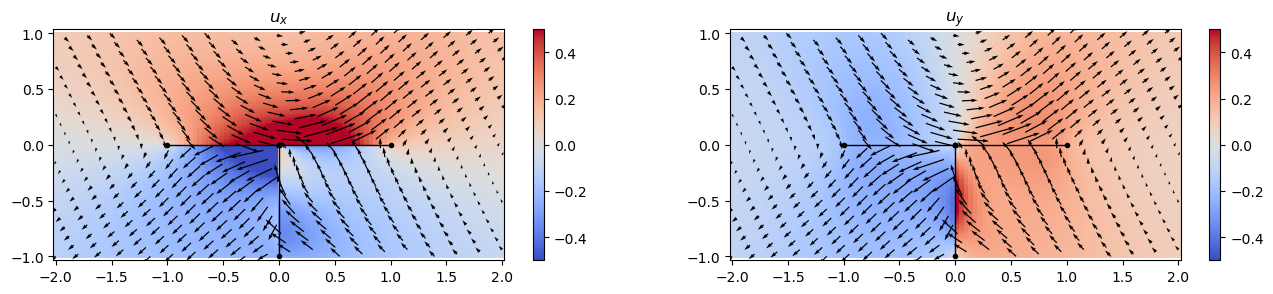

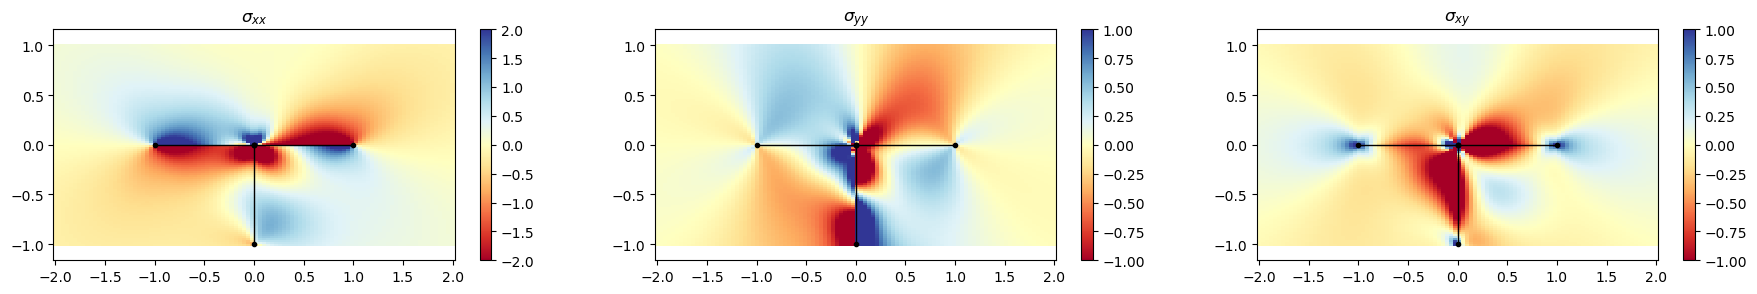

In [44]:
nskip_plot = 21 # plotting for vectors

# displacements
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()


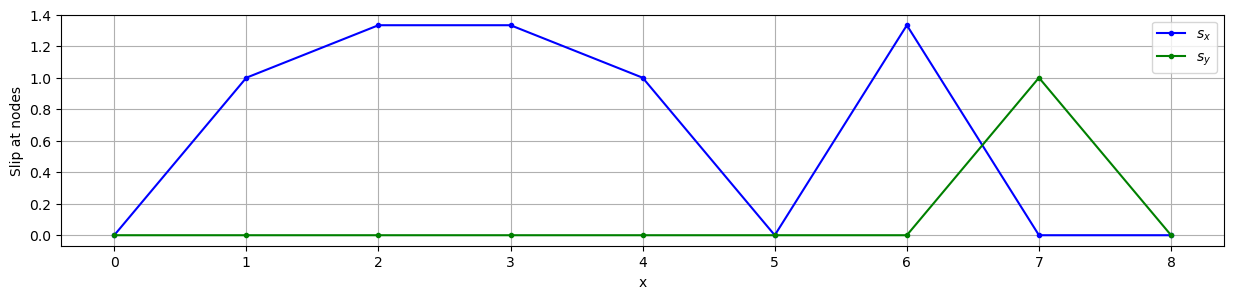

In [45]:
# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x,slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3*len(elements),1))
slip_nodes_n = np.zeros((3*len(elements),1))

for i in range(len(elements)):
    dummy = slip_vector[3*i:3*(i+1),:]@elements[i]["rotation_matrix"]
    slip_nodes_s[3*i:3*(i+1),0] = dummy[:,0]
    slip_nodes_n[3*i:3*(i+1),0] = dummy[:,1]

xnodes = np.zeros((3*len(elements),1))
xnodes[0::3,0] = x1
xnodes[2::3,0] = x2
xnodes[1::3,0] = 0.5*(x1 + x2)

plt.figure(figsize=(15,3))
plt.plot(slip_nodes_x,'b.-',label='$s_x$')
plt.plot(slip_nodes_y,'g.-',label='$s_y$')
# plt.plot(xnodes[1:-1:3,0],slip_nodes_x[1:-1:3,0],'bo',label='$s_x$ at centers')
# plt.plot(xnodes[1:-1:3,0],slip_nodes_y[1:-1:3,0],'go',label='$s_y$ at centers')
plt.xlabel("x")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()